In [1]:
from tensorflow.keras import backend as K
K.clear_session()
!pip install rarfile
import os
import pandas as pd
import gdown
import rarfile
import shutil
from PIL import Image

#https://drive.google.com/file/d/1O0_qr4yHPDp_O36wS59mVvyYiX3c9pYk/view?usp=drive_link



url = 'https://drive.google.com/uc?id=1O0_qr4yHPDp_O36wS59mVvyYiX3c9pYk'
output_rar = '/content/SDR.rar'
gdown.download(url, output_rar, quiet=False)
# Extract the RAR file
with rarfile.RarFile(output_rar, 'r') as rar_ref:
    rar_ref.extractall('/content')
# Path to the extracted dataset folder
dataset_folder = '/content/SDR'

Downloading...
From (original): https://drive.google.com/uc?id=1O0_qr4yHPDp_O36wS59mVvyYiX3c9pYk
From (redirected): https://drive.google.com/uc?id=1O0_qr4yHPDp_O36wS59mVvyYiX3c9pYk&confirm=t&uuid=7c85723b-79d8-4402-a856-a59b063f1f57
To: /content/SDR.rar
100%|██████████| 231M/231M [00:05<00:00, 41.5MB/s]


## DenseNet201

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import numpy as np
import os
def dense_block(x, blocks, name):
    """A dense block"""
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x

def transition_block(x, reduction, name):
    """A transition block"""
    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1
    x = tf.keras.layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_bn')(x)
    x = tf.keras.layers.Activation('relu', name=name + '_relu')(x)
    x = tf.keras.layers.Conv2D(int(tf.keras.backend.int_shape(x)[bn_axis] * reduction), 1,
                      use_bias=False,
                      name=name + '_conv')(x)
    x = tf.keras.layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

def conv_block(x, growth_rate, name):
    """A building block for a dense block"""
    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1
    x1 = tf.keras.layers.BatchNormalization(axis=bn_axis,
                                   epsilon=1.001e-5,
                                   name=name + '_0_bn')(x)
    x1 = tf.keras.layers.Activation('relu', name=name + '_0_relu')(x1)
    x1 = tf.keras.layers.Conv2D(4 * growth_rate, 1,
                       use_bias=False,
                       name=name + '_1_conv')(x1)
    x1 = tf.keras.layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_1_bn')(x1)
    x1 = tf.keras.layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = tf.keras.layers.Conv2D(growth_rate, 3,
                       padding='same',
                       use_bias=False,
                       name=name + '_2_conv')(x1)
    x = tf.keras.layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x

def DenseNet(blocks, input_shape, num_classes=10):
    img_input = tf.keras.layers.Input(shape=input_shape)

    bn_axis = 3 if tf.keras.backend.image_data_format() == 'channels_last' else 1

    x = tf.keras.layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
    x = tf.keras.layers.Conv2D(64, 7, strides=2, use_bias=False, name='conv1\conv')(x)
    x = tf.keras.layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1\bn')(x)
    x = tf.keras.layers.Activation('relu', name='conv1\relu')(x)
    x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, name='pool1')(x)

    x = dense_block(x, blocks[0], name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, blocks[1], name='conv3')
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, blocks[2], name='conv4')
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, blocks[3], name='conv5')

    x = tf.keras.layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = tf.keras.layers.Activation('relu', name='relu')(x)

    x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(x)

    model = tf.keras.models.Model(img_input, x, name='densenet')

    return model

model = DenseNet([6, 12, 48, 32],
                 input_shape=(224, 224, 3),
                 num_classes=5)

model.summary()

Model: "densenet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1\conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1n              │ (None, 112, 112,  │        256 │ conv1\conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1elu            │ (None, 112, 112,  │          0 │ conv1n[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1elu[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,331,589 (69.93 MB)

 Trainable params: 18,102,533 (69.06 MB)

 Non-trainable params: 229,056 (894.75 KB)

# **Fold#1** Train DenseNet201

Found 2674 images belonging to 3 classes.
Found 666 images belonging to 3 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6293 - loss: 0.9512
Epoch 1: val_accuracy improved from -inf to 0.78378, saving model to /content/Split/Save/best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.6301 - loss: 0.9489 - val_accuracy: 0.7838 - val_loss: 0.5766
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7419 - loss: 0.6147
Epoch 2: val_accuracy did not improve from 0.78378
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.7420 - loss: 0.6148 - val_accuracy: 0.7778 - val_loss: 0.5658
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7612 - loss: 0.5857
Epoch 3: val_accuracy did not improve from 0.78378
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.7612 - loss: 0.5858 - val_accuracy: 0.7763 - val_loss: 0.5379
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7645 - loss: 0.5660
Epoch 4: val_accuracy did not improve from 0.78378
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.7

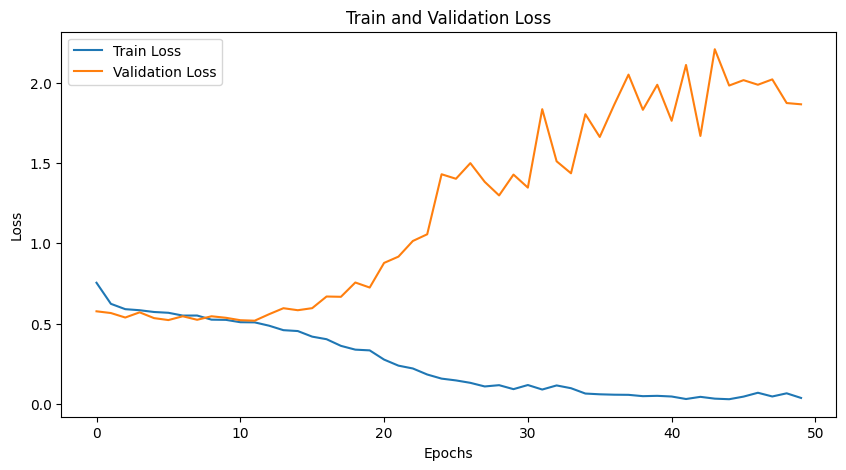

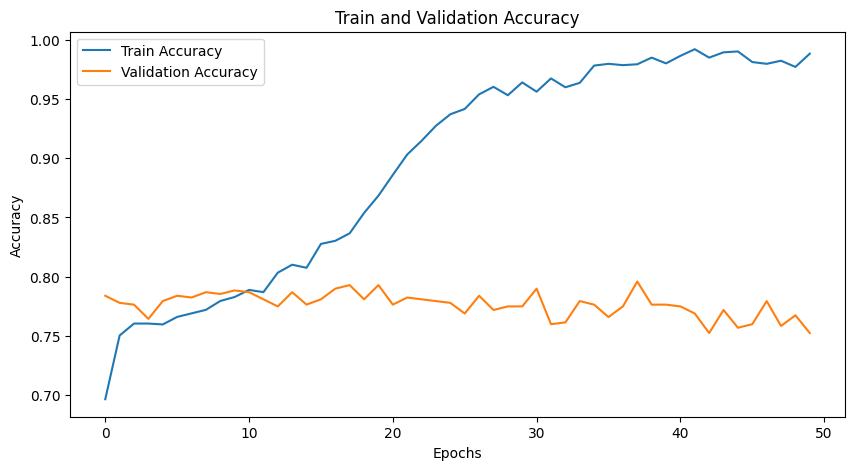

In [12]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up paths and parameters
data_dir = '/content/Gradding 3C/Train'  # Path to your dataset
img_size = (224, 224)
batch_size = 32
epochs = 50

# Create ImageDataGenerator for training and validation with rescaling
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data generator
train_data_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# Validation data generator
validation_data_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

# Define the CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 2 classes: DR and NDR
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint callback to save the best weights
best_weights_path = '/content/Split/Save/best_model.keras'
os.makedirs(os.path.dirname(best_weights_path), exist_ok=True)  # Create directory if it does not exist
checkpoint = ModelCheckpoint(best_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_data_generator,
    epochs=epochs,
    validation_data=validation_data_generator,
    verbose=1,
    callbacks=[checkpoint]
)

# Plot train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

# Plot train and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()


# **Fold#1** Test DenseNet201

In [13]:
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved best weights
best_weights_path = '/content/Split/Save/best_model.keras'
model.load_weights(best_weights_path)

# Define the dataset directory
TestSet = '/content/Gradding 3C/Test'


# Create an ImageDataGenerator for test data
datagen = ImageDataGenerator(rescale=1.0/255)  # You can add other preprocessing steps here

test_data_generator = datagen.flow_from_directory(
    TestSet,
    target_size=img_size,  # Set your target image size (e.g., (224, 224))
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle the test data
)

# Get true labels and predicted labels
y_true = test_data_generator.classes
y_pred = np.argmax(model.predict(test_data_generator), axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Found 838 images belonging to 3 classes.
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step
Test Accuracy: 0.7696897374701671
Test Precision: 0.7474062906922766
Test Recall: 0.7696897374701671
Test F1-score: 0.7515401954436917
Confusion Matrix:
[[361  22  12]
 [ 28 257  28]
 [  9  94  27]]
